<a href="https://colab.research.google.com/github/aksalas/Car-Sales/blob/main/Car_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library

In [2]:
# Imports

# Pandas
import pandas as pd
# Numpy
import numpy as np
# MatPlotLib
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer, make_column_selector
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingRegressor

# Models
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor



# Regression Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
# Set the default transformation output to Pandas
from sklearn import set_config
set_config(transform_output='pandas')
set_config(display='diagram') # 'text' or 'diagram'}
from IPython.core.display import clear_output

# Functions

In [3]:
def eval_regression(true, pred, name='Model'):

    """Evaluates true and predicted values from a regression model.
    Outputs a dataframe of metrics"""

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['RMSE'] = [np.sqrt(mean_squared_error(true, pred))]
    scores['MAE'] = [mean_absolute_error(true, pred)]
    scores['R2'] = [r2_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

def eval_classification(true, pred, name='Model'):

    """shows classification_report and confusion matrix
    for classification model predictions.  Outputs a dataframe of metrics"""

    print(name, '\n')
    print(classification_report(true, pred))
    ConfusionMatrixDisplay.from_predictions(true, pred)
    plt.show()

    scores = pd.DataFrame()
    scores['Model Name'] = [name]
    scores['Precision'] = [precision_score(true, pred)]
    scores['Recall'] = [recall_score(true, pred)]
    scores['F1 Score'] = [f1_score(true, pred)]
    scores['Accuracy'] = [accuracy_score(true, pred)]
    scores.set_index('Model Name', inplace=True)

    return scores

In [4]:
## Create a function to take the true and predicted values
## and print MAE, MSE, RMSE, and R2 metrics
def evaluate_regression(pipe, X_train, y_train, X_test, y_test,
                       model_name='Regression Model'):

  """Takes a regression model, training features and target and testing features and target.
  Returns a dataframe of regression metrics"""

  ## Predictions
  train_pred = pipe.predict(X_train)
  test_preds = pipe.predict(X_test)

  metrics = ['train_MAE','test_MAE',
             'train_RMSE', 'test_RMSE',
             'train_R2', 'test_R2']

  ## Train
  train_mae = round(mean_absolute_error(y_train, train_pred),4)
  train_rmse = round(np.sqrt(mean_squared_error(y_train, train_pred)),4)
  train_r2 = round(r2_score(y_train, train_pred),4)

  ## Test
  test_mae = round(mean_absolute_error(y_test, test_preds),4)
  test_rmse = round(np.sqrt(mean_squared_error(y_test, test_preds)),4)
  test_r2 = round(r2_score(y_test, test_preds),4)

  ## Output Dataframe
  scores = pd.DataFrame(columns=metrics, index=[model_name])
  scores.loc[model_name, :] = [train_mae, test_mae,
                              train_rmse, test_rmse,
                              train_r2, test_r2]

  return scores

In [5]:
def explore_numeric(df, x, figsize=(6,5) ):


  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes

In [6]:

def regression_metrics(y_true, y_pred, label='', verbose=True, output_dict=False):

  """Helper Function
  This custom function accept true targets and predictions with custom label
  Calculate and print  MAE, MSE , RMSE and R2 scores by saving it in a dictionary"""

  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics



In [7]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_metrics(y_true, y_pred):
    """
    Calculate regression metrics including MAE, MSE, RMSE, and R-squared.

    Args:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.

    Returns:
        dict: A dictionary containing regression metrics.
    """
    metrics = {}

    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    metrics['R2'] = r2_score(y_true, y_pred)

    return metrics


In [8]:
# Set MatPlotLib default parameters

plt.rcParams.update({'figure.facecolor': 'white',
                          'font.weight': 'bold',
                      'patch.linewidth': 1.25,
                       'axes.facecolor': 'white',
                       'axes.edgecolor': 'black',
                       'axes.linewidth': 2,
                       'axes.titlesize': 14,
                     'axes.titleweight': 'bold',
                       'axes.labelsize': 12,
                     'axes.labelweight': 'bold',
                      'xtick.labelsize': 10,
                      'ytick.labelsize': 10,
                            'axes.grid': True,
                       'axes.grid.axis': 'y',
                           'grid.color': 'black',
                       'grid.linewidth': .5,
                           'grid.alpha': .25,
                   'scatter.edgecolors': 'black'})

## Car sales data

In [9]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vQfLicudcbONFoaem30aKFT18It9CkP16yt9BcU2ogNwp1dlAS1GKFYgltolRw7jWQdMkE4wtsmqa26/pub?output=csv')

In [10]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4,Automatic,Front,04-May,Left wheel,Silver,4


In [11]:
df.shape

(19237, 18)

1. https://www.kaggle.com/datasets/sidharth178/car-prices-dataset?select=train.csv
2. Prices for each car sold
3. target = Price
4. a row represents a car
5. Categorical
6. 18 features
7. 19237 rows
8. I dont see any forseeable challenges with this dataset as of yet.

# EDA

## Car Price

In [12]:
# rows and columns
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 19237 rows, and 18 columns.
The rows represent 19237 observations, and the columns represent 17 features and 1 target variable.


In [13]:
# looking at dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                19237 non-null  int64 
 1   Price             19237 non-null  int64 
 2   Levy              19237 non-null  object
 3   Manufacturer      19237 non-null  object
 4   Model             19237 non-null  object
 5   Prod. year        19237 non-null  int64 
 6   Category          19237 non-null  object
 7   Leather interior  19237 non-null  object
 8   Fuel type         19237 non-null  object
 9   Engine volume     19237 non-null  object
 10  Mileage           19237 non-null  object
 11  Cylinders         19237 non-null  int64 
 12  Gear box type     19237 non-null  object
 13  Drive wheels      19237 non-null  object
 14  Doors             19237 non-null  object
 15  Wheel             19237 non-null  object
 16  Color             19237 non-null  object
 17  Airbags     

In [14]:
# categorical data
df.describe(include='object')

,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Mileage,Gear box type,Drive wheels,Doors,Wheel,Color
count,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237,19237
unique,559,65,1590,11,2,7,107,7687,4,3,3,2,16
top,-,HYUNDAI,Prius,Sedan,Yes,Petrol,2,0 km,Automatic,Front,04-May,Left wheel,Black
freq,5819,3769,1083,8736,13954,10150,3916,721,13514,12874,18332,17753,5033


In [15]:
# numeric data
df.describe(include='number')

,ID,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,4.557654e+07,1.855593e+04,2010.912824,4.582991,6.582627
std,9.365914e+05,1.905813e+05,5.668673,1.199933,4.320168
min,2.074688e+07,1.000000e+00,1939.000000,1.000000,0.000000
25%,4.569837e+07,5.331000e+03,2009.000000,4.000000,4.000000
50%,4.577231e+07,1.317200e+04,2012.000000,4.000000,6.000000
75%,4.580204e+07,2.207500e+04,2015.000000,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,16.000000,16.000000


In [16]:
df['Mileage'] = df['Mileage'].str.replace(' km', '')
df['Mileage'] = df['Mileage'].astype(int)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                19237 non-null  int64 
 1   Price             19237 non-null  int64 
 2   Levy              19237 non-null  object
 3   Manufacturer      19237 non-null  object
 4   Model             19237 non-null  object
 5   Prod. year        19237 non-null  int64 
 6   Category          19237 non-null  object
 7   Leather interior  19237 non-null  object
 8   Fuel type         19237 non-null  object
 9   Engine volume     19237 non-null  object
 10  Mileage           19237 non-null  int64 
 11  Cylinders         19237 non-null  int64 
 12  Gear box type     19237 non-null  object
 13  Drive wheels      19237 non-null  object
 14  Doors             19237 non-null  object
 15  Wheel             19237 non-null  object
 16  Color             19237 non-null  object
 17  Airbags     

## Duplicates

In [18]:
# checking to see any duplicated rows
df.duplicated().sum()

313

In [19]:
# dropping the duplicated rows rows
df = df.drop_duplicates()

In [20]:
# Checking again to see if they were properly dropped
df.duplicated().sum()

0

## Missing Values

In [21]:
df.isna().sum().sum()
# No need to deal with missing values

0

In [22]:
for col in df.select_dtypes('object'):
  print(col, df[col].nunique())

Levy 559
Manufacturer 65
Model 1590
Category 11
Leather interior 2
Fuel type 7
Engine volume 107
Gear box type 4
Drive wheels 3
Doors 3
Wheel 2
Color 16


In [23]:
df['Engine volume'].value_counts()

2            3856
2.5          2246
1.8          1743
1.6          1446
1.5          1289
             ... 
6.8             1
6.7             1
3.1             1
0.8 Turbo       1
1.1 Turbo       1
Name: Engine volume, Length: 107, dtype: int64

## Dropping Unnecessary columns
- the ID numer and the location of the steering wheel arent necessary to determine price of the car

In [24]:
# Dataframe Correlations
corr = df.corr()

# tabular view of correlation values
corr

<ipython-input-24-0f26864d7af3>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


,ID,Price,Prod. year,Mileage,Cylinders,Airbags
ID,1.000000,-0.000797,0.072030,0.004225,-0.040617,-0.022070
Price,-0.000797,1.000000,0.012689,-0.001763,0.007435,-0.012709
Prod. year,0.072030,0.012689,1.000000,-0.064058,-0.099443,0.235160
Mileage,0.004225,-0.001763,-0.064058,1.000000,-0.001720,-0.009174
Cylinders,-0.040617,0.007435,-0.099443,-0.001720,1.000000,0.174112
Airbags,-0.022070,-0.012709,0.235160,-0.009174,0.174112,1.000000


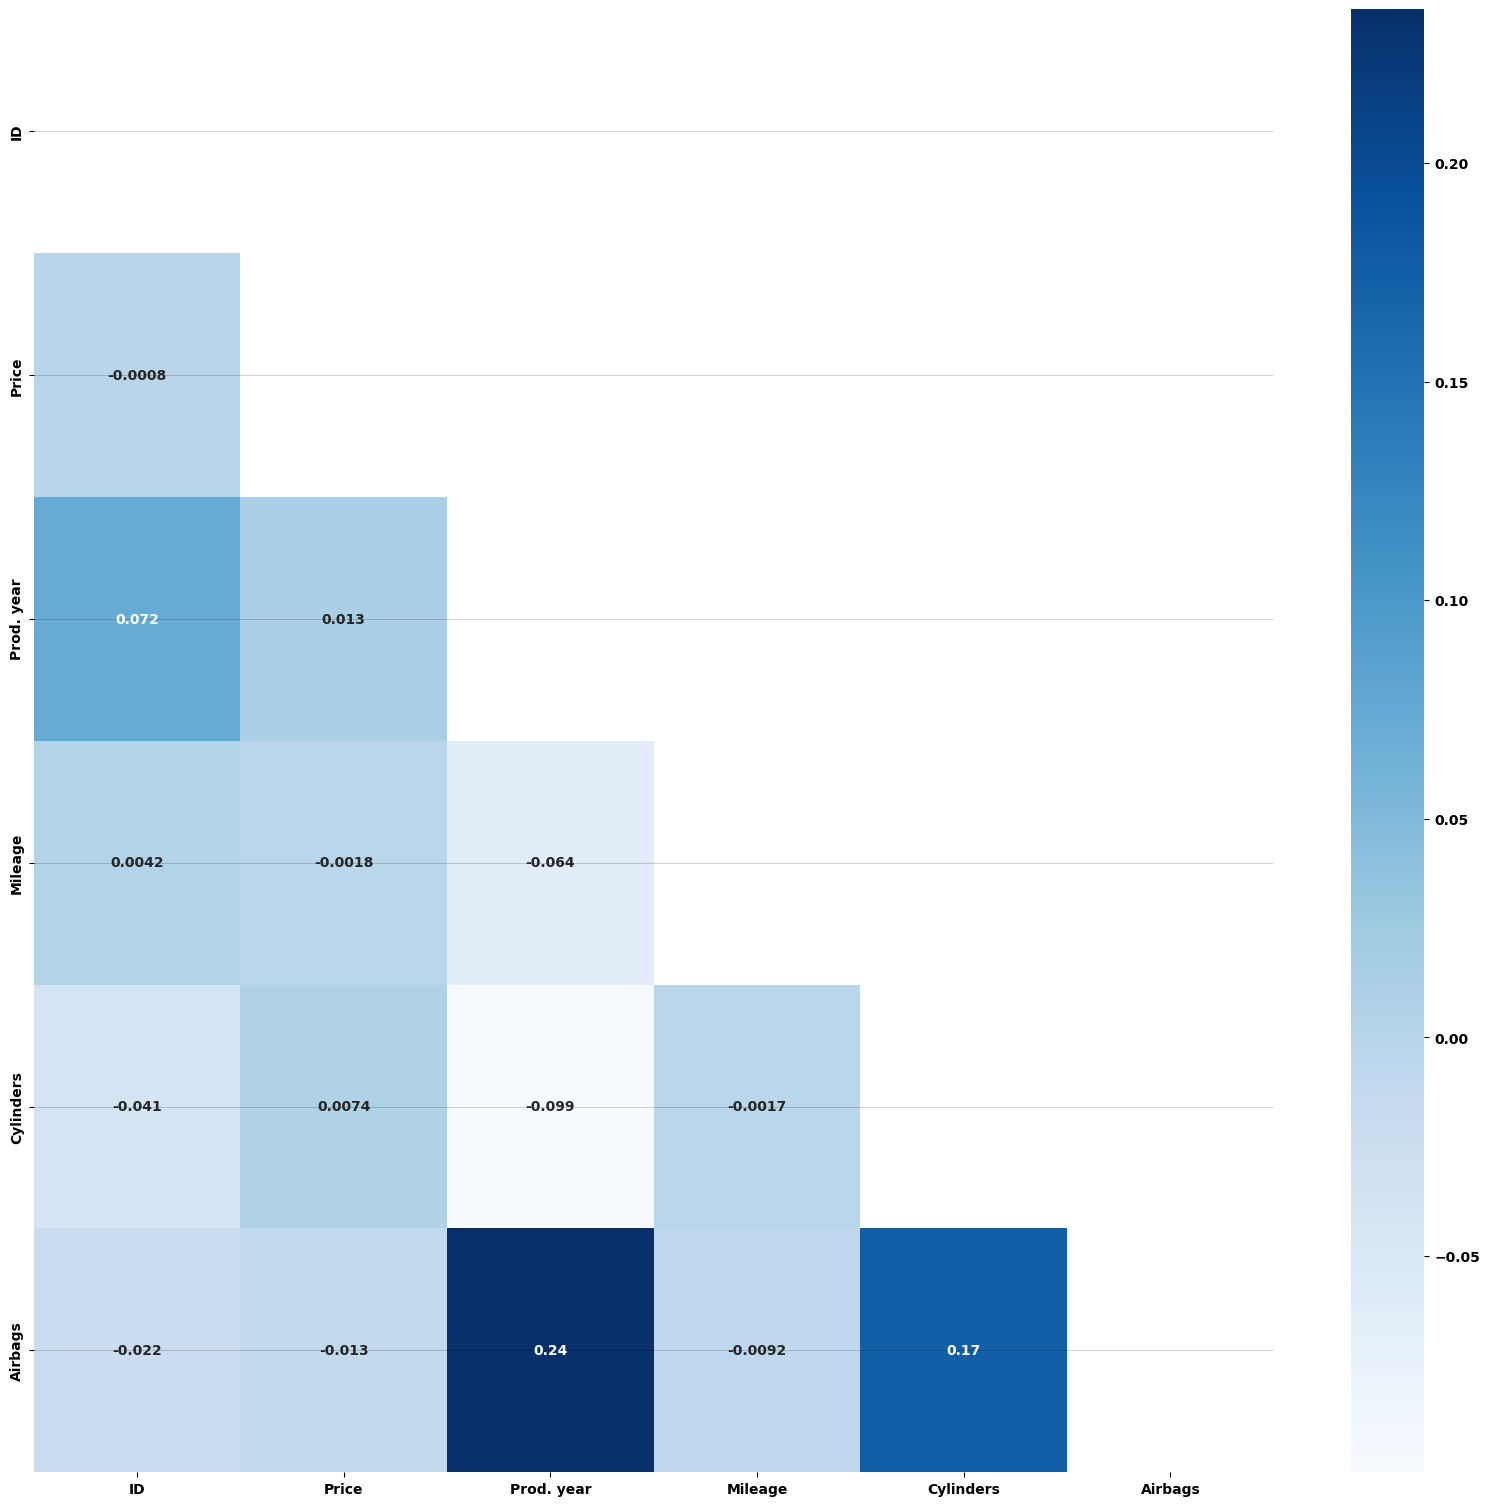

In [25]:
# code for heatmap

mask = np.triu(np.ones_like(corr))
fig, ax = plt.subplots(figsize = (20,19))
sns.heatmap(corr, cmap= 'Blues', annot = True, mask = mask);

In [26]:
df.drop(columns=['Levy','ID','Airbags','Mileage'])

,Price,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color
0,13328,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,6,Automatic,4x4,04-May,Left wheel,Silver
1,16621,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,6,Tiptronic,4x4,04-May,Left wheel,Black
2,8467,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,4,Variator,Front,04-May,Right-hand drive,Black
3,3607,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,4,Automatic,4x4,04-May,Left wheel,White
4,11726,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,4,Automatic,Front,04-May,Left wheel,Silver
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,8467,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,4,Manual,Rear,02-Mar,Left wheel,Silver
19233,15681,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,4,Tiptronic,Front,04-May,Left wheel,Red
19234,26108,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,4,Automatic,Front,04-May,Left wheel,Grey
19235,5331,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,4,Automatic,Front,04-May,Left wheel,Black


## Outliers

- No extreme outliers
  - There are mileage rows that are 0
  - There are cars with 16 airbags and some that are 0

In [27]:
df.describe(include="number")

,ID,Price,Prod. year,Mileage,Cylinders,Airbags
count,1.892400e+04,1.892400e+04,18924.000000,1.892400e+04,18924.000000,18924.000000
mean,4.557538e+07,1.858744e+04,2010.914236,1.555373e+06,4.580216,6.568379
std,9.375468e+05,1.921356e+05,5.665749,4.880221e+07,1.200223,4.322323
min,2.074688e+07,1.000000e+00,1939.000000,0.000000e+00,1.000000,0.000000
25%,4.569501e+07,5.331000e+03,2009.000000,7.019575e+04,4.000000,4.000000
50%,4.577191e+07,1.317200e+04,2012.000000,1.264000e+05,4.000000,6.000000
75%,4.580174e+07,2.206300e+04,2015.000000,1.891198e+05,4.000000,12.000000
max,4.581665e+07,2.630750e+07,2020.000000,2.147484e+09,16.000000,16.000000


In [28]:
df.describe(include="object")

,Levy,Manufacturer,Model,Category,Leather interior,Fuel type,Engine volume,Gear box type,Drive wheels,Doors,Wheel,Color
count,18924,18924,18924,18924,18924,18924,18924,18924,18924,18924,18924,18924
unique,559,65,1590,11,2,7,107,4,3,3,2,16
top,-,HYUNDAI,Prius,Sedan,Yes,Petrol,2,Automatic,Front,04-May,Left wheel,Black
freq,5709,3729,1069,8600,13731,9944,3856,13282,12695,18032,17471,4944


In [29]:
df['Mileage'].value_counts()

0         714
200000    181
150000    159
160000    120
180000    117
         ... 
100563      1
354300      1
21178       1
110539      1
186923      1
Name: Mileage, Length: 7687, dtype: int64

In [30]:
df['Mileage'] = df['Mileage'].astype(int)

## Univariate Visuals

### Price by fuel type analysis

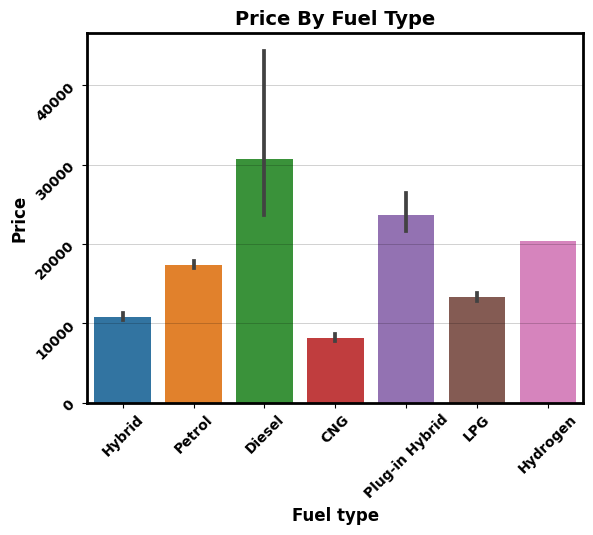

In [31]:
ax = sns.barplot(data=df,
                 x= 'Fuel type',
                 y = 'Price')

ax.tick_params(rotation = 45)

# Title
ax.set_title('Price By Fuel Type');

- Here we see that hybrid cars and diesel have the highest prices associated with them.
- Cars that use diesel have the highest prices assoicated with them.
- Contrary to diesel, the plug in hybrid are consistantly priced high as well


### Price by color analysis

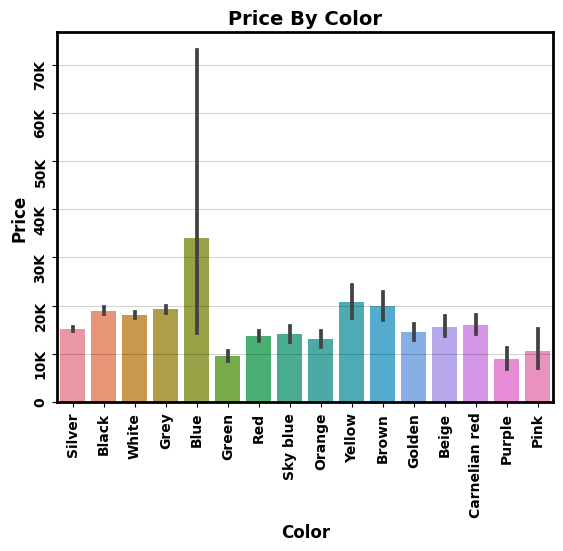

In [32]:
ax = sns.barplot(data=df,
                 x= 'Color',
                 y = 'Price')
def format_large_tick_values(tick_val, pos):
    if tick_val >= 1e3:
        val = int(tick_val) / 1e3
        return f'{val:.0f}K'
    else:
        return int(tick_val)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(format_large_tick_values))

ax.tick_params(rotation = 90)

# Title
ax.set_title('Price By Color');

- Blue cars have the more expensive cars.
- all the other cars have similar pricing amongst them.

Text(0.5, 1.0, 'Price by Category')

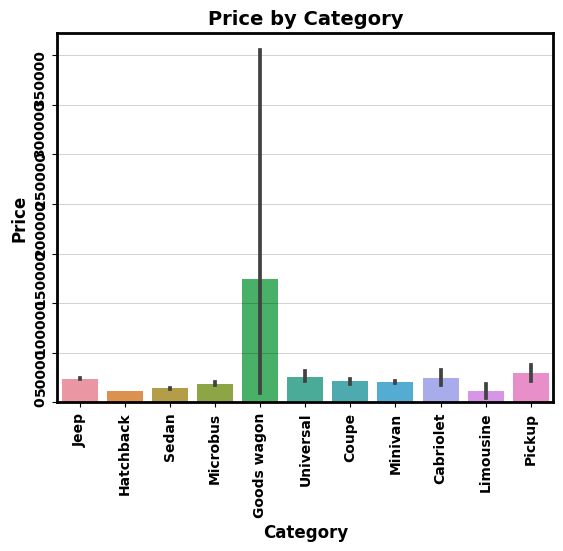

In [33]:
ax = sns.barplot(data=df,
                   x='Category',
                   y='Price')
ax.tick_params(rotation = 90)
ax.set_title('Price by Category')

Text(0.5, 1.0, 'Number of model types')

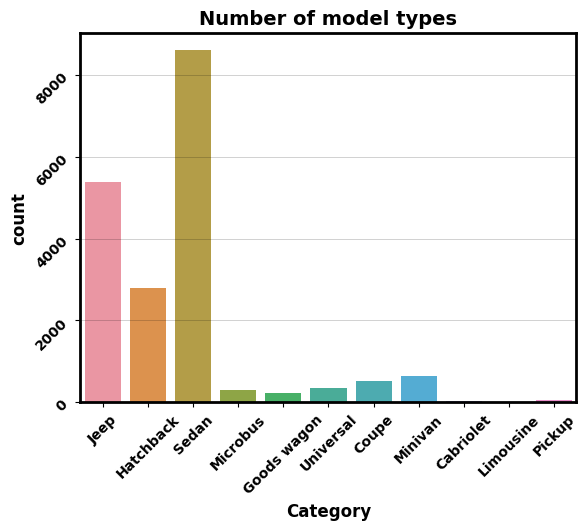

In [34]:
ax = sns.countplot(data=df,
                   x='Category',)
ax.tick_params(rotation = 45)
ax.set_title('Number of model types')

- Here we see that Sedans are the most common car type are Sedans but also have a smaller price point compared to goods wagons

Text(0.5, 1.0, 'Price by Year')

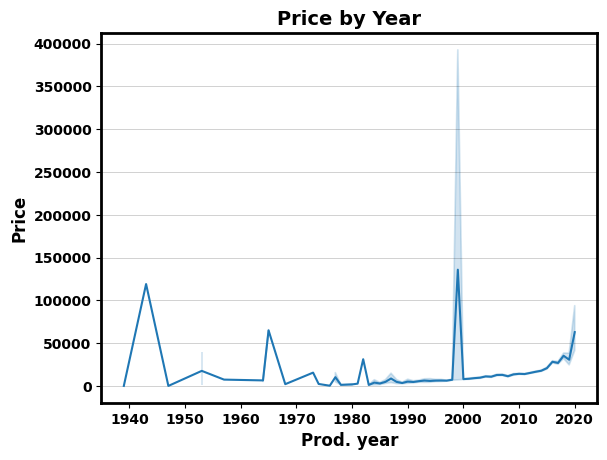

In [35]:
ax = sns.lineplot(data=df,
                  x='Prod. year',
                  y='Price')
ax.set_title('Price by Year')

- The price throughout the years have slightly increased with notable price spikes in 1940s, 1960, and 2000

# Modeling

In [36]:
X = df.drop(columns=['Price'])
y = df['Price']

In [37]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, random_state=42)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18924 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ID                18924 non-null  int64 
 1   Price             18924 non-null  int64 
 2   Levy              18924 non-null  object
 3   Manufacturer      18924 non-null  object
 4   Model             18924 non-null  object
 5   Prod. year        18924 non-null  int64 
 6   Category          18924 non-null  object
 7   Leather interior  18924 non-null  object
 8   Fuel type         18924 non-null  object
 9   Engine volume     18924 non-null  object
 10  Mileage           18924 non-null  int64 
 11  Cylinders         18924 non-null  int64 
 12  Gear box type     18924 non-null  object
 13  Drive wheels      18924 non-null  object
 14  Doors             18924 non-null  object
 15  Wheel             18924 non-null  object
 16  Color             18924 non-null  object
 17  Airbags     

In [39]:
# instantiate transformers
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

cat_cols = make_column_selector(dtype_include='object')
num_cols = make_column_selector(dtype_include='number')
# create preprocessing pipeline
preprocessor = make_column_transformer((ohe, cat_cols), (scaler, num_cols),remainder='drop', verbose_feature_names_out=False)

#pipeline

# Examine the results of all transformers
preprocessor.fit_transform(X_train,y_train).shape

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(14193, 2059)

## Evaluation

In [40]:
# Create an instance of the model
lin_reg = LinearRegression()
# Create a model pipeline
lin_reg_pipe = make_pipeline(preprocessor, lin_reg)


## Fit the model
lin_reg_pipe.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e308819fe50>),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7e308819f8e0>)],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [ ]:
## Model predictions
train_preds = dummy_pipe.predict(X_train)
test_preds = dummy_pipe.predict(X_test)

## Inspect predictions
train_preds[:5]

In [ ]:
## Training Metrics
print(f'MAE Train {mean_absolute_error(y_train, train_preds)}')
print(f'RMSE Train {np.sqrt(mean_squared_error(y_train, train_preds))}')
print(f'R2 Train {r2_score(y_train, train_preds)}')

print()
## Testing Metrics
print(f'MAE test {mean_absolute_error(y_test, test_preds)}')
print(f'RMSE test {np.sqrt(mean_squared_error(y_test, test_preds))}')
print(f'R2 test {r2_score(y_test, test_preds)}')

In [41]:
bagreg = BaggingRegressor(random_state = 42)
bagreg_pipe = make_pipeline(preprocessor, bagreg)
bagreg_pipe.fit(X_train, y_train)
evaluate_regression(bagreg_pipe, X_train, y_train, X_test, y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,train_MAE,test_MAE,train_RMSE,test_RMSE,train_R2,test_R2
Regression Model,2656.5704,6611.4808,66382.608,153305.6036,0.9103,-69.5601


In [42]:
bagreg_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('onehotencoder',
                                    OneHotEncoder(handle_unknown='ignore',
                                                  sparse=False),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7e308819fe50>),
                                   ('standardscaler', StandardScaler(),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7e308819f8e0>)],
                     verbose_feature_names_out=False)),
  ('baggingregressor', BaggingRegressor(random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('onehotencoder',
                                  OneHotEncoder(handle_unknown='ignore',
                                                sparse=False),
                                  <sklearn.compose._column_transformer.make_column_selector objec

In [ ]:
bagreg_pipe = make_pipeline(preprocessor, BaggingRegressor())

param_grid = {'baggingregressor__n_estimators': [5, 10, 20, 30, 40, 50],
              'baggingregressor__max_samples' : [1, 2, 10, ],
              'baggingregressor__max_features': [1, 5, 10 ]}
# Instaniate the gridsearch
gridsearch = GridSearchCV(bagreg_pipe, param_grid, n_jobs=-1, verbose=1)
# Fit the gridsearch on the training data
bag_gs = GridSearchCV(bagreg_pipe, param_grid,scoring='recall_macro').fit(X_train, y_train)

# Obtain the best paramters from the gridsearch
print(f'Best Params: {bag_gs.best_params_}')


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-pack

In [ ]:
evaluate_regression(bag_gs, X_train, y_train, X_test, y_test)

In [ ]:
rf = RandomForestRegressor(random_state = 42)
rf_pipe = make_pipeline(preprocessor, rf)
rf_pipe.fit(X_train, y_train)
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

In [ ]:
rf_pipe.get_params()

In [ ]:
rf_pipe = make_pipeline(preprocessor, RandomForestRegressor())

param_grid = {'randomforestregressor__min_samples_leaf': [2,3,4],
              'randomforestregressorr__max_samples' : [1, 5, 10,],
              'randomforestregressor__max_features': ['sqrt', 'log2', 'None', 1],}
# Fit the gridsearch on the training data
rf_gs = GridSearchCV(rf_pipe, param_grid).fit(X_train, y_train)


# Obtain the best paramters from the gridsearch
print(f'Best Params: {rf_gs.best_params_}')


In [ ]:
get_scorer_names()